#### Вхідні дані вже розбиті на тренувальну та тестову частини, це є добре. 
#### Є можливість завантажити дані напряму, але у pytorch є вбудований датасет Fashion-MNIST (https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST)
#### На що посилаються творці самого датасету (https://github.com/zalandoresearch/fashion-mnist). 
#### Спробуємо використати це, замість того, щоб намагатись прочитати .gz файли

#### Завантажимо датасет та підготуємо для входу в мережу

In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

In [4]:
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

In [4]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

подивимось що знаходиться у датасетах

#### відомо, що кожен приклад відноситься до одного з лейблів:

Label	Description
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot

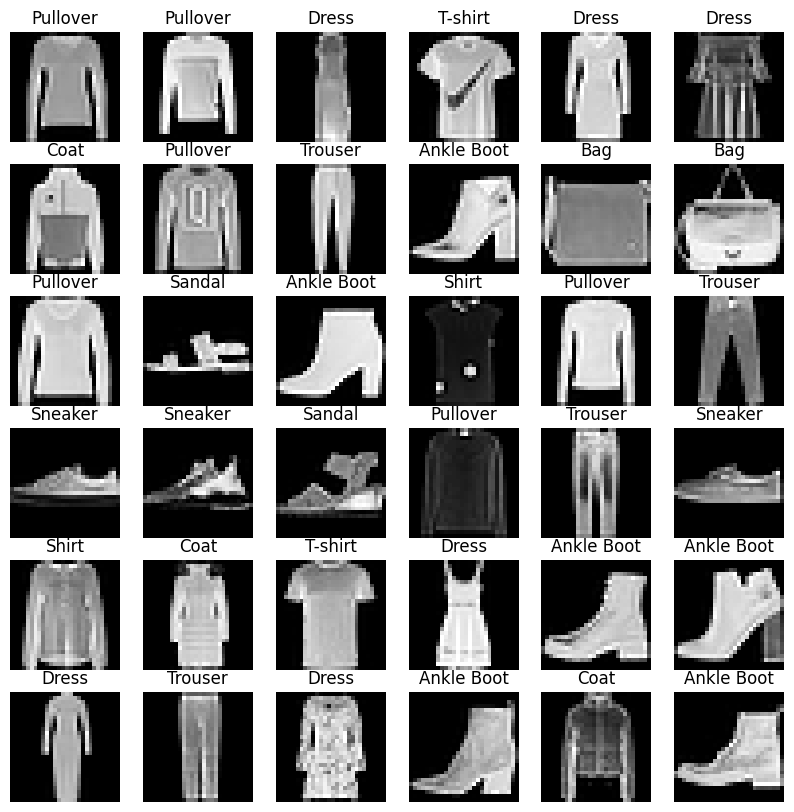

In [6]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 6, 6

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

### Створення дата завантажувальників (DataLoaders)

shape X [N, C, H, W]: torch.Size([64, 1, 28, 28])
shape y: torch.Size([64]) <built-in method type of Tensor object at 0x1035910d0>


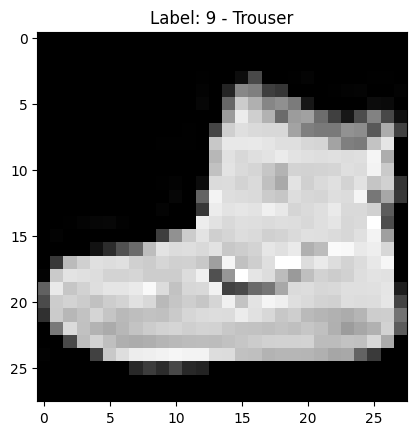

labels batch shape: torch.Size([64])


In [7]:
batch_size = 64

train_dl= DataLoader(train_data, batch_size = batch_size)
test_dl = DataLoader(test_data, batch_size=batch_size)

for X,y in train_dl:
    train_features, train_labels = next(iter(train_dl))
    print(f'shape X [N, C, H, W]: {X.shape}')
    print(f'shape y: {y.shape} {y.type}')
    image = train_features[0].squeeze()
    label = train_labels[0]
    sample_idx= torch.randint((label), size = (1,)).item()
    plt.title(f"Label: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"labels batch shape: {train_labels.size()}")
    break

In [8]:
images_size = 28

In [9]:
torch.manual_seed(12345)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Щільна нейронна мережа

In [11]:
class FFM(nn.Module):
    #ініціалізація моделі з вхідним розміром, розмірами трьох прихованих шарів і розміром вихідного шару
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, labels_size):
        super(self.__class__, self).__init__() #виклик конструктора батьківського класу
        #нормалізація пакету для двомірних даних (використовується для вхідного шару)
        self.batch1 = nn.BatchNorm2d(num_features=1)
         #нормалізація пакету для одновимірних даних (використовується для двох прихованих шарів)
        self.batch2 = nn.BatchNorm1d(num_features=hidden_size_1)
        self.batch3 = nn.BatchNorm1d(num_features=hidden_size_2)
        #лінійні шари, що перетворюють дані з попередніх шарів
        self.linear1 = nn.Linear(input_size * input_size * 1, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.linear4 = nn.Linear(hidden_size_3, labels_size)
         #функції активації Tanh для кожного з лінійних шарів
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()
        
        
    def forward(self, X):
        #застосування нормалізації пакету до вхідних даних
        X = self.batch1(X)
         #згортання даних у одновимірний масив перед подачею на лінійні шари
        X = torch.flatten(input=X, start_dim=1)
         #проходження через лінійні шари і функції активації
        X = self.linear1(X)
        X = self.tanh1(X)
        X = self.batch2(X)
        X = self.linear2(X)
        X = self.tanh2(X)
        X = self.batch3(X)
        X = self.linear3(X)
        X = self.tanh3(X)
        #вихідний шар, що перетворює дані в кінцеві мітки класів
        out = self.linear4(X)
        
        return out

In [12]:
#створюємо екземпляр моделі FFM з певними параметрами
model = FFM(
    input_size=images_size, #вхідний розмір даних (розмір зображень Fashion MNIST)
    hidden_size_1=images_size * 2, #розмір першого прихованого шару
    hidden_size_2=images_size, #розмір другого прихованого шару
    hidden_size_3=images_size // 2, #розмір третього прихованого шару
    labels_size=len(labels_map)  #кількість міток класів (10 класів у Fashion MNIST)
)
#переміщення моделі на пристрій
model.to(device)

FFM(
  (batch1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=784, out_features=56, bias=True)
  (linear2): Linear(in_features=56, out_features=28, bias=True)
  (linear3): Linear(in_features=28, out_features=14, bias=True)
  (linear4): Linear(in_features=14, out_features=10, bias=True)
  (tanh1): Tanh()
  (tanh2): Tanh()
  (tanh3): Tanh()
)

In [13]:
epoch_loss_values = []
step_loss_values = []

In [14]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [15]:
#встановлюємо кількість епох для тренування моделі
n_epochs = 50
#обчислюємо кількість ітерацій на епоху
n_iters = len(train_data_loader)
#допоміжна змінна для форматування виводу номера епохи
n_tab = str(len(str(n_epochs)))

#починаємо цикл тренування моделі, який виконується протягом заданої кількості епох
for epoch in range(n_epochs):
    epoch_loss = 0  #ініціалізуємо змінну для накопичення загальної втрати в епосі
    
    #ітеруємо по кожному пакету даних в тренувальному наборі
    for current_batch in train_data_loader:
        optimizer.zero_grad()  #обнуляємо градієнти для оптимізатора
        
        X_batch, Y_batch = current_batch  #витягуємо дані та мітки з поточного пакету
        X_batch = X_batch.type(torch.FloatTensor).to(device)  #перетворюємо дані в FloatTensor і переміщаємо на пристрій
        Y_batch = Y_batch.to(device)  #переміщаємо мітки на пристрій

        Y_pred = model(X_batch)  #виконуємо пряме поширення моделі
        
        #розраховуємо втрату між прогнозами моделі та правдивими мітками
        loss = loss_function(Y_pred.squeeze(), torch.flatten(Y_batch))
        step_loss_values.append(loss)  #зберігаємо значення втрати

        #додаємо втрату від поточного пакету до загальної втрати епохи
        epoch_loss += loss.item() / n_iters
        
        loss.backward()  #виконуємо зворотне поширення для обчислення градієнтів
        optimizer.step()  #оновлюємо ваги моделі
    
    epoch_loss_values.append(epoch_loss)  #зберігаємо середню втрату за епоху
    
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss))    


epoch  1: epoch_loss: 0.5590717681308293
epoch  2: epoch_loss: 0.4063114564556046
epoch  3: epoch_loss: 0.36708255185247224
epoch  4: epoch_loss: 0.3463903700968604
epoch  5: epoch_loss: 0.3237558904963777
epoch  6: epoch_loss: 0.31446651208883714
epoch  7: epoch_loss: 0.3003019608223615
epoch  8: epoch_loss: 0.29183199793608733
epoch  9: epoch_loss: 0.2852869559246215
epoch 10: epoch_loss: 0.27766478944943185
epoch 11: epoch_loss: 0.27104247305025914
epoch 12: epoch_loss: 0.26489778676393966
epoch 13: epoch_loss: 0.25864349293715144
epoch 14: epoch_loss: 0.25692078351243713
epoch 15: epoch_loss: 0.2499845123955055
epoch 16: epoch_loss: 0.24399282304303962
epoch 17: epoch_loss: 0.2407649904410085
epoch 18: epoch_loss: 0.23660966774611616
epoch 19: epoch_loss: 0.2339685389490079
epoch 20: epoch_loss: 0.2270706247911649
epoch 21: epoch_loss: 0.22976951262176956
epoch 22: epoch_loss: 0.22291848304937656
epoch 23: epoch_loss: 0.22397202089714816
epoch 24: epoch_loss: 0.2188959497688358
epo

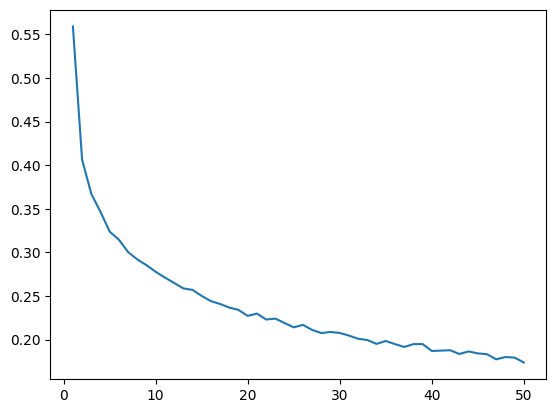

In [16]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [18]:
del step_loss_values
del epoch_loss_values

In [19]:
#створюємо порожній масив numpy для зберігання прогнозованих міток тренувального набору даних
Y_predicted_train = np.empty([0])

#використовуємо контекст 'torch.no_grad()' для вимкнення розрахунку градієнтів під час прогнозування
with torch.no_grad():
    #ітеруємо по кожному пакету тренувального завантажувача даних
    for current_batch in train_data_loader:
        
        #розділяємо дані та мітки поточного пакету
        X_batch, Y_batch = current_batch
        #конвертуємо дані в FloatTensor та переміщуємо на пристрій
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        #переміщуємо мітки на  пристрій
        Y_batch = Y_batch.to(device)

        #виконуємо пряме поширення моделі для отримання вихідних даних на основі вхідного пакету
        Y_pred = model(X_batch)
        #застосовуємо softmax для перетворення вихідних значень моделі на ймовірності класів
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        #отримуємо індекс класу з найвищою ймовірністю для кожного елементу в пакеті
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        #конвертуємо прогнози в масив numpy та додаємо їх до загального масиву прогнозованих міток
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_train = np.append(Y_predicted_train, Y_pred_label)
        
        #видаляємо використані змінні для звільнення пам'яті
        del X_batch
        del Y_batch
        del Y_pred_label
        #очищуємо кеш
        torch.cuda.empty_cache()

Y_predicted_train.shape


(60000,)

In [20]:
#створюємо порожній масив numpy для зберігання прогнозованих міток тестового набору даних
Y_predicted_test = np.empty([0])

#використовуємо контекст 'torch.no_grad()' для вимкнення розрахунку градієнтів під час прогнозування
with torch.no_grad():
    #ітеруємо по кожному пакету тестового завантажувача даних
    for current_batch in test_data_loader:
        
        #розділяємо дані та мітки поточного пакету
        X_batch, Y_batch = current_batch
        #конвертуємо дані в FloatTensor та переміщуємо на пристрій
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        #переміщуємо мітки на пристрій
        Y_batch = Y_batch.to(device)

        #виконуємо пряме поширення моделі для отримання вихідних даних на основі вхідного пакету
        Y_pred = model(X_batch)
        #застосовуємо softmax для перетворення вихідних значень моделі на ймовірності класів
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        #отримуємо індекс класу з найвищою ймовірністю для кожного елементу в пакеті
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        #конвертуємо прогнози в масив numpy та додаємо їх до загального масиву прогнозованих міток
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_test = np.append(Y_predicted_test, Y_pred_label)
        
        #видаляємо використані змінні для звільнення пам'яті
        del X_batch
        del Y_batch
        del Y_pred_label
        #очищуємо кеш
        torch.cuda.empty_cache()
        
Y_predicted_test.shape


(10000,)

In [21]:
#дістаємо лейбли
Y_train_labels = [label for _, label in train_data]
Y_test_labels = [label for _, label in test_data]

In [22]:
#переводимо лейбли в масив
Y_train_labels = np.array(Y_train_labels)
Y_test_labels = np.array(Y_test_labels)

In [23]:
Y_train_labels.shape, Y_test_labels.shape

((60000,), (10000,))

In [25]:
conf_matr_train = multilabel_confusion_matrix(
    y_true=Y_train_labels.squeeze(), 
    y_pred=Y_predicted_train.astype(int)
)

for k, label in enumerate(labels_map.values()):
    print(label)
    print(conf_matr_train[k])

T-shirt
[[53177   823]
 [  516  5484]]
Trouser
[[53933    67]
 [   46  5954]]
Pullover
[[53164   836]
 [  722  5278]]
Dress
[[53652   348]
 [  432  5568]]
Coat
[[53048   952]
 [  791  5209]]
Sandal
[[53952    48]
 [   50  5950]]
Shirt
[[53079   921]
 [ 1426  4574]]
Sneaker
[[53913    87]
 [  167  5833]]
Bag
[[53942    58]
 [   74  5926]]
Ankle Boot
[[53839   161]
 [   77  5923]]


In [26]:
conf_matr_test = multilabel_confusion_matrix(
    y_true=Y_test_labels.squeeze(), 
    y_pred=Y_predicted_test.astype(int)
)

for k, label in enumerate(labels_map.values()):
    print(label)
    print(conf_matr_test[k])

T-shirt
[[8786  214]
 [ 163  837]]
Trouser
[[8964   36]
 [  31  969]]
Pullover
[[8737  263]
 [ 215  785]]
Dress
[[8881  119]
 [ 144  856]]
Coat
[[8755  245]
 [ 221  779]]
Sandal
[[8949   51]
 [  56  944]]
Shirt
[[8728  272]
 [ 366  634]]
Sneaker
[[8932   68]
 [  67  933]]
Bag
[[8973   27]
 [  43  957]]
Ankle Boot
[[8942   58]
 [  47  953]]


In [27]:
#визначаємо функцію для створення великої матриці невідповідностей
def large_confusion_matrix(y_true, y_pred, num_labels, norm=False):
    #ініціалізуємо матрицю нулів
    output_matrix = np.zeros([num_labels, num_labels]).astype(int)

    #проходимо по кожному елементу в реальних та прогнозованих мітках
    for j in range(len(y_true)):
        #збільшуємо відповідну комірку в матриці
        output_matrix[int(y_true[j]), int(y_pred[j])] += 1

    if norm:
        #конвертуємо матрицю в тип float для нормалізації
        output_matrix = output_matrix.astype(float)

        #проходимо по кожному рядку матриці
        for j in range(num_labels):
            #обчислюємо суму значень в рядку
            row_sum = np.sum(output_matrix[j,])
            #якщо сума більша за 0, то нормалізуємо рядок
            if row_sum > 0:
                output_matrix[j,] /= row_sum
        output_matrix = np.round(output_matrix, 2)

    return output_matrix


In [28]:
conf_matrix = large_confusion_matrix(Y_test_labels, Y_predicted_test, 10, norm=True)

In [29]:
conf_matrix

array([[0.84, 0.01, 0.02, 0.02, 0.  , 0.  , 0.1 , 0.  , 0.01, 0.  ],
       [0.  , 0.97, 0.01, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.78, 0.01, 0.1 , 0.  , 0.07, 0.  , 0.  , 0.  ],
       [0.03, 0.02, 0.01, 0.86, 0.05, 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.11, 0.03, 0.78, 0.  , 0.07, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.94, 0.  , 0.03, 0.  , 0.02],
       [0.14, 0.  , 0.1 , 0.03, 0.08, 0.  , 0.63, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.93, 0.  , 0.04],
       [0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.  , 0.96, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.04, 0.  , 0.95]])

In [30]:
cfm_test = large_confusion_matrix(
    y_true=Y_test_labels, 
    y_pred=Y_predicted_test.astype(int), 
    num_labels=10 
)

In [31]:
correct_predictions = np.sum(np.diag(cfm_test))

total_test_samples = len(Y_test_labels) 
accuracy = correct_predictions / total_test_samples

print("Accuracy:", accuracy)

Accuracy: 0.8647


In [32]:
conf_matrix_train = large_confusion_matrix(Y_train_labels, Y_predicted_train, 10, norm=True)

In [33]:
conf_matrix_train

array([[0.91, 0.  , 0.02, 0.01, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.88, 0.  , 0.06, 0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.02, 0.01, 0.01, 0.93, 0.03, 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.06, 0.02, 0.87, 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  ],
       [0.11, 0.  , 0.06, 0.01, 0.06, 0.  , 0.76, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]])

In [34]:
#використовуємо функцію large_confusion_matrix для створення матриці помилок на основі тренувальних даних
cfm_train = large_confusion_matrix(
    y_true=Y_train_labels,  #реальні мітки з тренувального набору даних
    y_pred=Y_predicted_train.astype(int),  #прогнозовані мітки з тренувального набору даних
    num_labels=10  #в Fashion MNIST є 10 класів
)

#обчислюємо кількість правильних прогнозів
#np.diag витягує діагональні елементи матриці (правильні прогнози)
correct_predictions = np.sum(np.diag(cfm_train))

#ділимо кількість правильних прогнозів на загальну кількість тренувальних зразків
total_train_samples = len(Y_train_labels)  #загальна кількість тренувальних зразків
accuracy = correct_predictions / total_train_samples

# Друкуємо розраховану точність.
print("Accuracy:", accuracy)

Accuracy: 0.9283166666666667


In [35]:
#функція для обчислення точності
def calculate_accuracy(y_true, y_pred):
    #розрахунок кількості правильних прогнозів
    correct_predictions = np.sum(y_true == y_pred)
    #визначення загальної кількості зразків
    total_samples = len(y_true)
    #повернення відношення правильних прогнозів до загальної кількості зразків
    return correct_predictions / total_samples

#розрахунок точності для навчального набору даних
#припустимо, що Y_predicted_train та Y_train_labels доступні та мають відповідні форми
train_accuracy = calculate_accuracy(Y_train_labels, Y_predicted_train.astype(int))

#розрахунок точності для тестового набору даних
#припустимо, що Y_predicted_test та Y_test_labels доступні та мають відповідні форми
test_accuracy = calculate_accuracy(Y_test_labels, Y_predicted_test.astype(int))

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

#перевірка на перенавчання (overfitting)
if train_accuracy > test_accuracy:
    if train_accuracy - test_accuracy > 0.1:  
        print("Potential overfitting detected.")
    else:
        print("Slight difference in accuracies but might not be overfitting.")
else:
    print("No significant overfitting detected.")


Training Accuracy: 0.9283166666666667
Test Accuracy: 0.8647
Slight difference in accuracies but might not be overfitting.


Різниця між точністю на тренувальних та тестових даних складає 6,36%. Fashion MNIST є датасетом, що часто використовують в університетах/ на різних конкурсах, тому можна спробувати сказати, що він має бути "стерильним". Тому скажемо, що 6,36% означатиме перенавчання. Спробуємо використати згорткову нейронну мережу з Dropout шаром.

In [40]:
#визначення класу CNN, що є підкласом nn.Module
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_classes):
        super(CNN, self).__init__()  #виклик конструктора базового класу
        
        #перший згортковий шар
        self.conv1 = nn.Conv2d(1, hidden_size_1, kernel_size=3, stride=1, padding=1)
        #шар пулінгу для зменшення розмірності вихідних даних згорткового шару
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        reduced_size = input_size // 2

        #лінійні шари
        self.fc1 = nn.Linear(hidden_size_1 * reduced_size * reduced_size, hidden_size_2)
        self.fc2 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc3 = nn.Linear(hidden_size_3, num_classes)

        #шар відсіву (dropout) для запобігання перенавчанню
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        #застосування першого згорткового шару та шару пулінгу
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        #вирівнювання вихідних даних для подачі в лінійні шари
        x = x.view(-1, self.num_flat_features(x))

        #застосування лінійних шарів з функцією активації ReLU та шаром відсіву
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [41]:
model = CNN(input_size=28,  
                   hidden_size_1=32, 
                   hidden_size_2=64,  
                   hidden_size_3=128,
                   num_classes=10)    
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [42]:
epoch_loss_values = []
step_loss_values = []

In [43]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [44]:
n_epochs = 50
n_iters = len(train_dl)
n_tab = str(len(str(n_epochs)))

for epoch in range(n_epochs):
    epoch_loss = 0 
    
    for current_batch in train_dl:
        
        optimizer.zero_grad()
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        Y_pred = model(X_batch)
        
        loss = loss_function(Y_pred.squeeze(), torch.flatten(Y_batch))
        step_loss_values.append(loss)

        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
            
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss)) 

epoch  1: epoch_loss: 0.4826689782713268
epoch  2: epoch_loss: 0.3264865499140737
epoch  3: epoch_loss: 0.2828214513118075
epoch  4: epoch_loss: 0.25451634580027227
epoch  5: epoch_loss: 0.23635018283306658
epoch  6: epoch_loss: 0.2205077499699302
epoch  7: epoch_loss: 0.21188030418937884
epoch  8: epoch_loss: 0.19719513464393407
epoch  9: epoch_loss: 0.19049211114502038
epoch 10: epoch_loss: 0.18561651445289776
epoch 11: epoch_loss: 0.17470708503715518
epoch 12: epoch_loss: 0.1700571333425546
epoch 13: epoch_loss: 0.17063918760590455
epoch 14: epoch_loss: 0.16070446366273466
epoch 15: epoch_loss: 0.15314859401351247
epoch 16: epoch_loss: 0.1483252538380022
epoch 17: epoch_loss: 0.1524379302803149
epoch 18: epoch_loss: 0.14130424801359528
epoch 19: epoch_loss: 0.1421775429882902
epoch 20: epoch_loss: 0.14134440582686436
epoch 21: epoch_loss: 0.1360250821323204
epoch 22: epoch_loss: 0.12844612494931198
epoch 23: epoch_loss: 0.12311471750818753
epoch 24: epoch_loss: 0.13149355879541985
e

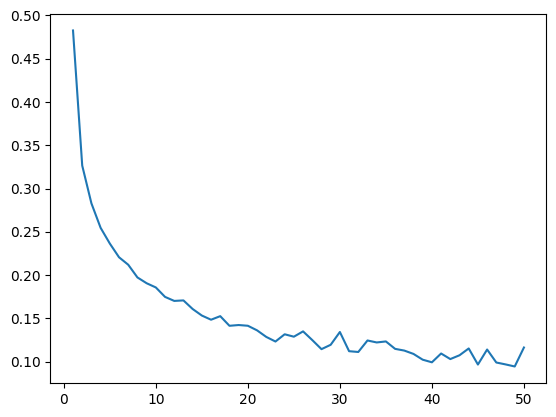

In [45]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [46]:
del step_loss_values
del epoch_loss_values

In [47]:
Y_predicted_train = np.empty([0])

with torch.no_grad():
    for current_batch in train_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_train = np.append(Y_predicted_train, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_train.shape

(60000,)

In [48]:
Y_predicted_test = np.empty([0])

with torch.no_grad():
    for current_batch in test_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)
        
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_test = np.append(Y_predicted_test, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_test.shape

(10000,)

In [49]:
conf_matr_train = multilabel_confusion_matrix(
    y_true=Y_train_labels.squeeze(), 
    y_pred=Y_predicted_train.astype(int)
)

for k, label in enumerate(labels_map.values()):
    print(label)
    print(conf_matr_train[k])

T-shirt
[[53804   196]
 [  471  5529]]
Trouser
[[53997     3]
 [   35  5965]]
Pullover
[[53529   471]
 [  435  5565]]
Dress
[[53746   254]
 [  144  5856]]
Coat
[[53769   231]
 [  724  5276]]
Sandal
[[53997     3]
 [   40  5960]]
Shirt
[[52915  1085]
 [  436  5564]]
Sneaker
[[53928    72]
 [   58  5942]]
Bag
[[53981    19]
 [   33  5967]]
Ankle Boot
[[53936    64]
 [   22  5978]]


In [50]:
conf_matr_test = multilabel_confusion_matrix(
    y_true=Y_test_labels.squeeze(), 
    y_pred=Y_predicted_test.astype(int)
)

for k, label in enumerate(labels_map.values()):
    print(label)
    print(conf_matr_test[k])

T-shirt
[[8863  137]
 [ 191  809]]
Trouser
[[8989   11]
 [  24  976]]
Pullover
[[8833  167]
 [ 161  839]]
Dress
[[8898  102]
 [ 108  892]]
Coat
[[8871  129]
 [ 217  783]]
Sandal
[[8982   18]
 [  40  960]]
Shirt
[[8620  380]
 [ 234  766]]
Sneaker
[[8932   68]
 [  34  966]]
Bag
[[8980   20]
 [  26  974]]
Ankle Boot
[[8964   36]
 [  33  967]]


In [51]:
conf_matrix = large_confusion_matrix(Y_test_labels, Y_predicted_test, 10, norm=True)

In [52]:
conf_matrix

array([[0.81, 0.  , 0.02, 0.02, 0.01, 0.  , 0.13, 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.84, 0.01, 0.05, 0.  , 0.08, 0.  , 0.  , 0.  ],
       [0.02, 0.01, 0.01, 0.89, 0.02, 0.  , 0.06, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.08, 0.03, 0.78, 0.  , 0.09, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.96, 0.  , 0.03, 0.  , 0.01],
       [0.1 , 0.  , 0.05, 0.02, 0.05, 0.  , 0.77, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.97, 0.  , 0.03],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.97, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97]])

In [53]:
cfm_test = large_confusion_matrix(
    y_true=Y_test_labels, 
    y_pred=Y_predicted_test.astype(int), 
    num_labels=10 
)

In [54]:
correct_predictions = np.sum(np.diag(cfm_test))

total_test_samples = len(Y_test_labels)  
accuracy = correct_predictions / total_test_samples

print("Accuracy:", accuracy)

Accuracy: 0.8932


In [55]:
conf_matrix_train = large_confusion_matrix(Y_train_labels, Y_predicted_train, 10, norm=True)

In [56]:
conf_matrix_train

array([[0.92, 0.  , 0.01, 0.01, 0.  , 0.  , 0.06, 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.93, 0.  , 0.02, 0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.04, 0.02, 0.88, 0.  , 0.06, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  ],
       [0.03, 0.  , 0.02, 0.01, 0.01, 0.  , 0.93, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [57]:
cfm_train = large_confusion_matrix(
    y_true=Y_train_labels, 
    y_pred=Y_predicted_train.astype(int), 
    num_labels=10  
)
correct_predictions = np.sum(np.diag(cfm_train))

total_train_samples = len(Y_train_labels)  
accuracy = correct_predictions / total_train_samples

print("Accuracy:", accuracy)

Accuracy: 0.9600333333333333


In [58]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

train_accuracy = calculate_accuracy(Y_train_labels, Y_predicted_train.astype(int))

test_accuracy = calculate_accuracy(Y_test_labels, Y_predicted_test.astype(int))

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

if train_accuracy > test_accuracy:
    if train_accuracy - test_accuracy > 0.1:  
        print("Potential overfitting detected.")
    else:
        print("Slight difference in accuracies but might not be overfitting.")
else:
    print("No significant overfitting detected.")


Training Accuracy: 0.9600333333333333
Test Accuracy: 0.8932
Slight difference in accuracies but might not be overfitting.


Покращилась точність на тестовій вибірці, але трохи погіршилась на тренувальній вибірці. 
Тепер точність на тренувальній вибірці більша за точність на тестовій на 6,68%.
Спробуємо додати BatchNormalization та подивимось, як це вплине на результати.

In [59]:
#визначення класу AdaptedCNN, який є підкласом nn.Module
class AdaptedCNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, labels_size):
        super(AdaptedCNN, self).__init__()  #виклик конструктора базового класу
        
        #згортковий шар 
        self.conv1 = nn.Conv2d(1, hidden_size_1, kernel_size=3, stride=1, padding=1)
        #нормалізація пакету для згорткового шару
        self.bn1 = nn.BatchNorm2d(hidden_size_1)
        
        reduced_size = input_size // 2

        #лінійні шари
        self.fc1 = nn.Linear(hidden_size_1 * reduced_size * reduced_size, hidden_size_2)
        #нормалізація пакету для першого лінійногг шару
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.fc2 = nn.Linear(hidden_size_2, hidden_size_3)
        #нормалізація пакету для другого лінійного шару
        self.bn3 = nn.BatchNorm1d(hidden_size_3)
        self.fc3 = nn.Linear(hidden_size_3, labels_size)

        #функція активації
        self.tanh = nn.Tanh()

    def forward(self, x):
        #застосування згорткового шару, нормалізації пакету та активації
        x = F.tanh(self.bn1(self.conv1(x)))
        
        #шар пулінгу
        x = F.max_pool2d(x, 2)
        
        #вирівнювання вихідних даних для подачі в лінійні шари
        x = torch.flatten(x, start_dim=1)
        
        #лінійні шари з нормалізацією пакету та активацією
        x = self.tanh(self.bn2(self.fc1(x)))
        x = self.tanh(self.bn3(self.fc2(x)))
        x = self.fc3(x)

        return x


In [60]:
model = AdaptedCNN(input_size=28,  
                   hidden_size_1=32,  
                   hidden_size_2=64,  
                   hidden_size_3=128,
                   labels_size=10)  
model.to(device)

AdaptedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (tanh): Tanh()
)

In [61]:
epoch_loss_values = []
step_loss_values = []

In [62]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [63]:
n_epochs = 50
n_iters = len(train_dl)
n_tab = str(len(str(n_epochs)))

for epoch in range(n_epochs):
    epoch_loss = 0 
    
    for current_batch in train_dl:
        
        optimizer.zero_grad()
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        Y_pred = model(X_batch)
        
        loss = loss_function(Y_pred.squeeze(), torch.flatten(Y_batch))
        step_loss_values.append(loss)

        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
            
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss)) 

epoch  1: epoch_loss: 0.3856549438541885
epoch  2: epoch_loss: 0.26146512861444987
epoch  3: epoch_loss: 0.21314573281410834
epoch  4: epoch_loss: 0.17629213145038491
epoch  5: epoch_loss: 0.14775513492818512
epoch  6: epoch_loss: 0.12525171925351486
epoch  7: epoch_loss: 0.10756462189589322
epoch  8: epoch_loss: 0.09365821548098172
epoch  9: epoch_loss: 0.08188144292651128
epoch 10: epoch_loss: 0.07000197065564223
epoch 11: epoch_loss: 0.06171073484539077
epoch 12: epoch_loss: 0.05841945601788068
epoch 13: epoch_loss: 0.04654476647044339
epoch 14: epoch_loss: 0.04634367937100747
epoch 15: epoch_loss: 0.041467712897467875
epoch 16: epoch_loss: 0.03813506402924824
epoch 17: epoch_loss: 0.03687091987170003
epoch 18: epoch_loss: 0.030864938099824334
epoch 19: epoch_loss: 0.031671248993290005
epoch 20: epoch_loss: 0.027323930080091624
epoch 21: epoch_loss: 0.027993996098655823
epoch 22: epoch_loss: 0.023992811585329704
epoch 23: epoch_loss: 0.025345115417379452
epoch 24: epoch_loss: 0.0226

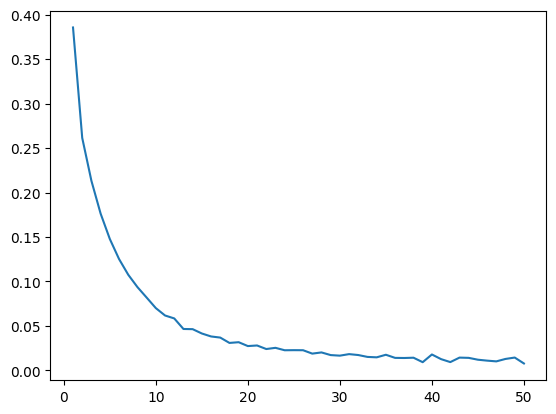

In [64]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [65]:
del step_loss_values
del epoch_loss_values

In [66]:
Y_predicted_train = np.empty([0])

with torch.no_grad():
    for current_batch in train_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_train = np.append(Y_predicted_train, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_train.shape

(60000,)

In [67]:
Y_predicted_test = np.empty([0])

with torch.no_grad():
    for current_batch in test_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_test = np.append(Y_predicted_test, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_test.shape

(10000,)

In [68]:
conf_matr_train = multilabel_confusion_matrix(
    y_true=Y_train_labels.squeeze(), 
    y_pred=Y_predicted_train.astype(int)
)

for k, label in enumerate(labels_map.values()):
    print(label)
    print(conf_matr_train[k])

T-shirt
[[53980    20]
 [   73  5927]]
Trouser
[[53997     3]
 [   34  5966]]
Pullover
[[53967    33]
 [   70  5930]]
Dress
[[53908    92]
 [   13  5987]]
Coat
[[53927    73]
 [   22  5978]]
Sandal
[[53993     7]
 [    1  5999]]
Shirt
[[53943    57]
 [   69  5931]]
Sneaker
[[53998     2]
 [   17  5983]]
Bag
[[53996     4]
 [    1  5999]]
Ankle Boot
[[53988    12]
 [    3  5997]]


In [69]:
conf_matr_test = multilabel_confusion_matrix(
    y_true=Y_test_labels.squeeze(), 
    y_pred=Y_predicted_test.astype(int)
)

for k, label in enumerate(labels_map.values()):
    print(label)
    print(conf_matr_test[k])

T-shirt
[[8889  111]
 [ 143  857]]
Trouser
[[8995    5]
 [  27  973]]
Pullover
[[8901   99]
 [ 149  851]]
Dress
[[8869  131]
 [  82  918]]
Coat
[[8829  171]
 [ 100  900]]
Sandal
[[8978   22]
 [  18  982]]
Shirt
[[8776  224]
 [ 241  759]]
Sneaker
[[8965   35]
 [  41  959]]
Bag
[[8981   19]
 [  20  980]]
Ankle Boot
[[8964   36]
 [  32  968]]


In [70]:
conf_matrix = large_confusion_matrix(Y_test_labels, Y_predicted_test, 10, norm=True)

In [71]:
conf_matrix

array([[0.86, 0.  , 0.01, 0.04, 0.  , 0.  , 0.08, 0.  , 0.  , 0.  ],
       [0.  , 0.97, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.85, 0.01, 0.07, 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.01, 0.92, 0.03, 0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.03, 0.02, 0.9 , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.01, 0.  , 0.01],
       [0.08, 0.  , 0.04, 0.04, 0.07, 0.  , 0.76, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.96, 0.  , 0.03],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]])

In [72]:
cfm_test = large_confusion_matrix(
    y_true=Y_test_labels, 
    y_pred=Y_predicted_test.astype(int), 
    num_labels=10  
)

In [73]:
correct_predictions = np.sum(np.diag(cfm_test))

total_test_samples = len(Y_test_labels)  
accuracy = correct_predictions / total_test_samples

print("Accuracy:", accuracy)

Accuracy: 0.9147


In [74]:
conf_matrix_train = large_confusion_matrix(Y_train_labels, Y_predicted_train, 10, norm=True)

In [75]:
conf_matrix_train

array([[0.99, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [76]:
cfm_train = large_confusion_matrix(
    y_true=Y_train_labels, 
    y_pred=Y_predicted_train.astype(int), 
    num_labels=10  
)
correct_predictions = np.sum(np.diag(cfm_train))


total_train_samples = len(Y_train_labels)  
accuracy = correct_predictions / total_train_samples

print("Accuracy:", accuracy)

Accuracy: 0.99495


In [77]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

train_accuracy = calculate_accuracy(Y_train_labels, Y_predicted_train.astype(int))

test_accuracy = calculate_accuracy(Y_test_labels, Y_predicted_test.astype(int))

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

if train_accuracy > test_accuracy:
    if train_accuracy - test_accuracy > 0.1: 
        print("Potential overfitting detected.")
    else:
        print("Slight difference in accuracies but might not be overfitting.")
else:
    print("No significant overfitting detected.")


Training Accuracy: 0.99495
Test Accuracy: 0.9147
Slight difference in accuracies but might not be overfitting.


Точність для і на тестовій і на тренувальній вибірках покращилась. Можна сказати, що ця модель є найкращою з трьох.